# Frequency basis experiments

Imports

In [77]:
import copy
import itertools
from typing import List

import matplotlib.pyplot as plt
# System imports
import numpy as np
import tensorflow as tf

# Building blocks
import c3.generator.devices as devices
# Libs and helpers
import c3.libraries.algorithms as algorithms
import c3.libraries.chip as chip
import c3.libraries.envelopes as envelopes
import c3.libraries.fidelities as fidelities
import c3.libraries.hamiltonians as hamiltonians
import c3.signal.gates as gates
import c3.signal.pulse as pulse
# Main C3 objects
from c3.c3objs import Quantity as Qty
from c3.experiment import Experiment as Exp
from c3.generator.generator import Generator as Gnr
from c3.model import Model as Mdl
from c3.parametermap import ParameterMap as PMap

Need 4 qubit levels to prevent optimising by taking advantage of the energy cutoff.

In [78]:
qubit_lvls = 4
freq_q1 = 5e9
anhar_q1 = -210e6
t1_q1 = 27e-6
t2star_q1 = 39e-6
qubit_temp = 50e-3

q1 = chip.Qubit(
    name="Q1",
    desc="Qubit 1",
    freq=Qty(value=freq_q1, min_val=4.995e9, max_val=5.005e9, unit='Hz 2pi'),
    anhar=Qty(value=anhar_q1, min_val=-380e6, max_val=-120e6, unit='Hz 2pi'),
    hilbert_dim=qubit_lvls,
    t1=Qty(value=t1_q1, min_val=1e-6, max_val=90e-6, unit='s'),
    t2star=Qty(value=t2star_q1, min_val=10e-6, max_val=90e-3, unit='s'),
    temp=Qty(value=qubit_temp, min_val=0.0, max_val=0.12, unit='K')
)

freq_q2 = 5.6e9
anhar_q2 = -240e6
t1_q2 = 23e-6
t2star_q2 = 31e-6
q2 = chip.Qubit(
    name="Q2",
    desc="Qubit 2",
    freq=Qty(value=freq_q2, min_val=5.595e9, max_val=5.605e9, unit='Hz 2pi'),
    anhar=Qty(value=anhar_q2, min_val=-380e6, max_val=-120e6, unit='Hz 2pi'),
    hilbert_dim=qubit_lvls,
    t1=Qty(value=t1_q2, min_val=1e-6, max_val=90e-6, unit='s'),
    t2star=Qty(value=t2star_q2, min_val=10e-6, max_val=90e-6, unit='s'),
    temp=Qty(value=qubit_temp, min_val=0.0, max_val=0.12, unit='K')
)

In [79]:
coupling_strength = 50e6
q1q2 = chip.Coupling(
    name="Q1-Q2",
    desc="coupling",
    comment="Coupling qubit 1 to qubit 2",
    connected=["Q1", "Q2"],
    strength=Qty(
        value=coupling_strength,
        min_val=-1 * 1e3,
        max_val=200e6,
        unit='Hz 2pi'
    ),
    hamiltonian_func=hamiltonians.int_XX
)

and each qubit has a drive line

In [80]:
drive1 = chip.Drive(
    name="d1",
    desc="Drive 1",
    comment="Drive line 1 on qubit 1",
    connected=["Q1"],
    hamiltonian_func=hamiltonians.x_drive
)
drive2 = chip.Drive(
    name="d2",
    desc="Drive 2",
    comment="Drive line 2 on qubit 2",
    connected=["Q2"],
    hamiltonian_func=hamiltonians.x_drive
)

All parts are collected in the model.

In [81]:
model = Mdl(
    [q1, q2],  # Individual, self-contained components
    [drive1, drive2, q1q2],  # Interactions between components
)
model.set_lindbladian(False)
model.set_dressed(True)

In [82]:
sim_res = 100e9  # Resolution for numerical simulation
awg_res = 2e9  # Realistic, limited resolution of an AWG
v2hz = 1e9

lo = devices.LO(name='lo', resolution=sim_res)
awg = devices.AWG(name='awg', resolution=awg_res)
mixer = devices.Mixer(name='mixer')
dig_to_an = devices.DigitalToAnalog(name="dac", resolution=sim_res)
v_to_hz = devices.VoltsToHertz(
    name='v_to_hz',
    V_to_Hz=Qty(value=v2hz, min_val=0.9e9, max_val=1.1e9, unit='Hz/V')
)

In [83]:
generator = Gnr(
    devices={
        "LO": lo,
        "AWG": awg,
        "DigitalToAnalog": dig_to_an,
        "Mixer": mixer,
        "VoltsToHertz": v_to_hz
    },
    chains={
        "d1": {
            "LO": [],
            "AWG": [],
            "DigitalToAnalog": ["AWG"],
            "Mixer": ["LO", "DigitalToAnalog"],
            "VoltsToHertz": ["Mixer"],
        },
        "d2": {
            "LO": [],
            "AWG": [],
            "DigitalToAnalog": ["AWG"],
            "Mixer": ["LO", "DigitalToAnalog"],
            "VoltsToHertz": ["Mixer"],
        }
    }
)

Here the stuff that's relevant for the frequency basis experiment is set up.

In [84]:
t_final_2Q = 45e-9
sideband = 50e6


def get_freq_envs(n_freqs: int, max_freq: float = max(-anhar_q1, -anhar_q2), max_amp: float = 3.,
                  max_init_amp: float = 3e-1):
    freqs_params = {
        'amps': Qty(value=np.random.uniform(0, max_init_amp, n_freqs), min_val=0, max_val=max_amp, unit="V"),
        'phases': Qty(value=np.random.uniform(-np.pi, np.pi, n_freqs), min_val=-np.pi, max_val=np.pi,
                      unit="rad"),
        'freqs': Qty(value=np.random.uniform(0, max_freq, n_freqs), min_val=0, max_val=max_freq,
                     unit='Hz 2pi'),
        't_final': Qty(value=t_final_2Q, min_val=0.5 * t_final_2Q, max_val=1.5 * t_final_2Q, unit="s"),
        'freq_offset': Qty(value=-sideband - 3e6, min_val=-56 * 1e6, max_val=-52 * 1e6, unit='Hz 2pi'),
    }

    freq_envs_2Q_1 = pulse.Envelope(
        name="freqs1",
        params=freqs_params,
        shape=envelopes.fourier_sin
    )
    freq_envs_2Q_2 = pulse.Envelope(
        name="freqs2",
        params=copy.deepcopy(freqs_params),
        shape=envelopes.fourier_sin
    )

    return freq_envs_2Q_1, freq_envs_2Q_2


In [85]:
lo_freq_q1 = freq_q1 + sideband
lo_freq_q2 = freq_q2 + sideband

carr_2Q_1 = pulse.Carrier(
    name="carrier",
    desc="Carrier on drive 1",
    params={
        'freq': Qty(value=lo_freq_q2, min_val=0.9 * lo_freq_q2, max_val=1.1 * lo_freq_q2, unit='Hz 2pi'),
        'framechange': Qty(value=0.0, min_val=-np.pi, max_val=3 * np.pi, unit='rad')
    }
)

carr_2Q_2 = pulse.Carrier(
    name="carrier",
    desc="Carrier on drive 2",
    params={
        'freq': Qty(value=lo_freq_q2, min_val=0.9 * lo_freq_q2, max_val=1.1 * lo_freq_q2, unit='Hz 2pi'),
        'framechange': Qty(value=0.0, min_val=-np.pi, max_val=3 * np.pi, unit='rad')
    }
)

TODO

In [86]:
gate_name = 'cz[0, 1]'


def setup_cx_exp(n_freqs):
    # CNOT controlled by qubit 1
    cnot12 = gates.Instruction(
        name="cz", targets=[0, 1], t_start=0.0, t_end=t_final_2Q, channels=["d1", "d2"],
        ideal=np.array([
            [1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, -1]
        ])
    )

    freqs1, freqs2 = get_freq_envs(n_freqs)

    cnot12.add_component(freqs1, "d1")
    cnot12.add_component(carr_2Q_1, "d1")
    cnot12.add_component(freqs2, "d2")
    cnot12.add_component(carr_2Q_2, "d2")
    cnot12.comps["d1"]["carrier"].params["framechange"].set_value(
        (-sideband * t_final_2Q) * 2 * np.pi % (2 * np.pi)
    )

    parameter_map = PMap(instructions=[cnot12], model=model, generator=generator)
    exp = Exp(pmap=parameter_map)

    return exp

In [87]:
exp = setup_cx_exp(15)

TODO

In [88]:
psi_init = [[0] * qubit_lvls ** 2]
psi_init[0][0] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
print(init_state)

tf.Tensor(
[[1.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]], shape=(16, 1), dtype=complex128)


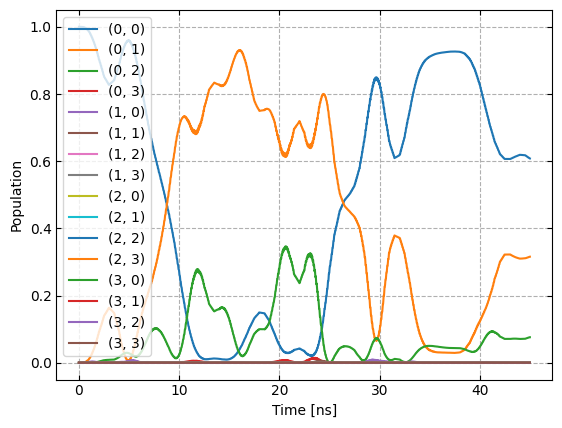

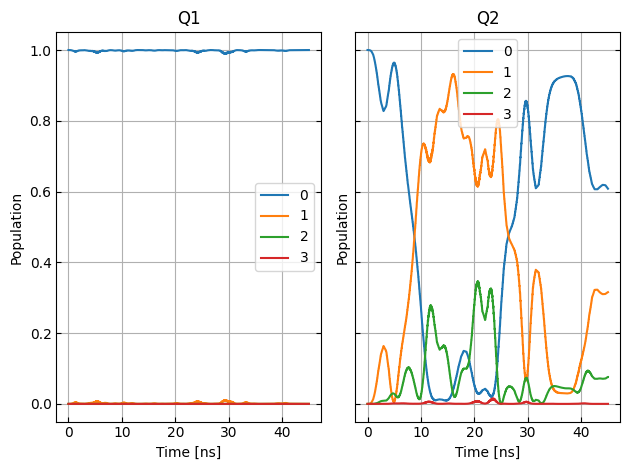

In [89]:
def plot_dynamics(exp, psi_init, seq):
    """
    Plotting code for time-resolved populations.

    Parameters
    ----------
    psi_init: tf.Tensor
        Initial state or density matrix.
    seq: list
        List of operations to apply to the initial state.
    """
    model = exp.pmap.model
    exp.compute_propagators()
    dUs = exp.partial_propagators
    psi_t = psi_init.numpy()
    pop_t = exp.populations(psi_t, model.lindbladian)
    for gate in seq:
        for du in dUs[gate]:
            psi_t = np.matmul(du.numpy(), psi_t)
            pops = exp.populations(psi_t, model.lindbladian)
            pop_t = np.append(pop_t, pops, axis=1)

    fig, axs = plt.subplots(1, 1)
    ts = exp.ts
    dt = ts[1] - ts[0]
    ts = np.linspace(0.0, dt * pop_t.shape[1], pop_t.shape[1])
    axs.plot(ts / 1e-9, pop_t.T)
    axs.grid(linestyle="--")
    axs.tick_params(
        direction="in", left=True, right=True, top=True, bottom=True
    )
    axs.set_xlabel('Time [ns]')
    axs.set_ylabel('Population')
    plt.legend(model.state_labels)
    pass


def getQubitsPopulation(population: np.array, dims: List[int]) -> np.array:
    """
    Splits the population of all levels of a system into the populations of levels per subsystem.
    Parameters
    ----------
    population: np.array
        The time dependent population of each energy level. First dimension: level index, second dimension: time.
    dims: List[int]
        The number of levels for each subsystem.
    Returns
    -------
    np.array
        The time-dependent population of energy levels for each subsystem. First dimension: subsystem index, second
        dimension: level index, third dimension: time.
    """
    numQubits = len(dims)

    # create a list of all levels
    qubit_levels = []
    for dim in dims:
        qubit_levels.append(list(range(dim)))
    combined_levels = list(itertools.product(*qubit_levels))

    # calculate populations
    qubitsPopulations = np.zeros((numQubits, dims[0], population.shape[1]))
    for idx, levels in enumerate(combined_levels):
        for i in range(numQubits):
            qubitsPopulations[i, levels[i]] += population[idx]
    return qubitsPopulations


def plotSplittedPopulation(
        exp: Exp,
        psi_init: tf.Tensor,
        sequence: List[str]
) -> None:
    """
    Plots time dependent populations for multiple qubits in separate plots.
    Parameters
    ----------
    exp: Experiment
        The experiment containing the model and propagators
    psi_init: np.array
        Initial state vector
    sequence: List[str]
        List of gate names that will be applied to the state
    -------
    """
    # calculate the time dependent level population
    model = exp.pmap.model
    dUs = exp.partial_propagators
    psi_t = psi_init.numpy()
    pop_t = exp.populations(psi_t, model.lindbladian)
    for gate in sequence:
        for du in dUs[gate]:
            psi_t = np.matmul(du, psi_t)
            pops = exp.populations(psi_t, model.lindbladian)
            pop_t = np.append(pop_t, pops, axis=1)
    dims = [s.hilbert_dim for s in model.subsystems.values()]
    splitted = getQubitsPopulation(pop_t, dims)

    # timestamps
    dt = exp.ts[1] - exp.ts[0]
    ts = np.linspace(0.0, dt * pop_t.shape[1], pop_t.shape[1])

    # create both subplots
    titles = list(exp.pmap.model.subsystems.keys())
    fig, axs = plt.subplots(1, len(splitted), sharey="all")
    for idx, ax in enumerate(axs):
        ax.plot(ts / 1e-9, splitted[idx].T)
        ax.tick_params(direction="in", left=True, right=True, top=False, bottom=True)
        ax.set_xlabel("Time [ns]")
        ax.set_ylabel("Population")
        ax.set_title(titles[idx])
        ax.legend([str(x) for x in np.arange(dims[idx])])
        ax.grid()

    plt.tight_layout()
    plt.show()


sequence = [gate_name]
plot_dynamics(exp, init_state, sequence)
plotSplittedPopulation(exp, init_state, sequence)

#### Open-loop optimal control

TODO

In [90]:
opt_gates = [gate_name]
exp.set_opt_gates(opt_gates)

gateset_opt_map = [
    [(gate_name, "d1", "freqs1", "amps")],
    [(gate_name, "d1", "freqs1", "freqs")],
    [(gate_name, "d1", "freqs1", "phases")],
    [(gate_name, "d1", "freqs1", "freq_offset")],
    [(gate_name, "d2", "freqs2", "amps")],
    [(gate_name, "d2", "freqs2", "freqs")],
    [(gate_name, "d2", "freqs2", "phases")],
    [(gate_name, "d2", "freqs2", "freq_offset")],
    [(gate_name, "d1", "carrier", "framechange")],
    [(gate_name, "d2", "carrier", "framechange")],
]
exp.pmap.set_opt_map(gateset_opt_map)

exp.pmap.print_parameters()

cz[0, 1]-d1-freqs1-amps               : <15 values>
cz[0, 1]-d1-freqs1-freqs              : <15 values>
cz[0, 1]-d1-freqs1-phases             : <15 values>
cz[0, 1]-d1-freqs1-freq_offset        : -53.000 MHz 2pi 
cz[0, 1]-d2-freqs2-amps               : <15 values>
cz[0, 1]-d2-freqs2-freqs              : <15 values>
cz[0, 1]-d2-freqs2-phases             : <15 values>
cz[0, 1]-d2-freqs2-freq_offset        : -53.000 MHz 2pi 
cz[0, 1]-d1-carrier-framechange       : 4.712 rad 
cz[0, 1]-d2-carrier-framechange       : 0.000 rad 



TODO

In [91]:
from c3.optimizers.optimalcontrol import OptimalControl

opt = OptimalControl(
    fid_func=fidelities.unitary_infid_set,
    fid_subspace=["Q1", "Q2"],
    pmap=exp.pmap,
    algorithm=algorithms.lbfgs,
    options={
        "maxfun": 250
    },
    run_name="cnot12"
)

Start the optimisation

In [92]:
exp.set_opt_gates(opt_gates)
opt.set_exp(exp)
opt.optimize_controls()

C3:STATUS:Saving as: C:\Users\YONATA~1\AppData\Local\Temp\tmpss8cb_vx\c3logs\cnot12\2023_08_26_T_23_17_48\open_loop.c3log


C:\Users\Yonatan Gideoni\Desktop\ML4Q\c3\c3\utils\utils.py:64: UserWarning: OSError encountered while creating symlink
  warnings.warn("OSError encountered while creating symlink")


  message: STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
  success: False
   status: 1
      fun: 0.0009600912505919323
        x: [-9.413e-01 -9.240e-01 ...  5.947e-03 -6.216e-01]
      nit: 223
      jac: [-9.255e-06 -2.710e-04 ...  1.590e-03 -3.056e-03]
     nfev: 251
     njev: 251
 hess_inv: <94x94 LbfgsInvHessProduct with dtype=float64>

The final parameters and the fidelity are

In [93]:
exp.pmap.print_parameters()
print(opt.current_best_goal)

cz[0, 1]-d1-freqs1-amps               : <15 values>
cz[0, 1]-d1-freqs1-freqs              : <15 values>
cz[0, 1]-d1-freqs1-phases             : <15 values>
cz[0, 1]-d1-freqs1-freq_offset        : -53.046 MHz 2pi 
cz[0, 1]-d2-freqs2-amps               : <15 values>
cz[0, 1]-d2-freqs2-freqs              : <15 values>
cz[0, 1]-d2-freqs2-phases             : <15 values>
cz[0, 1]-d2-freqs2-freq_offset        : -52.972 MHz 2pi 
cz[0, 1]-d1-carrier-framechange       : 3.179 rad 
cz[0, 1]-d2-carrier-framechange       : -764.241 mrad 

0.0009600912505919323


#### Results of the optimisation
Plotting the dynamics with the same initial state:

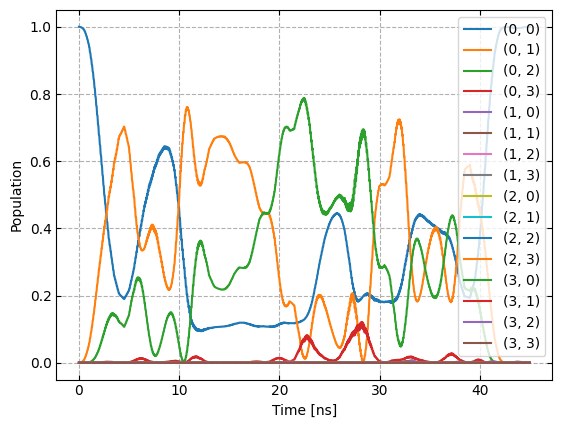

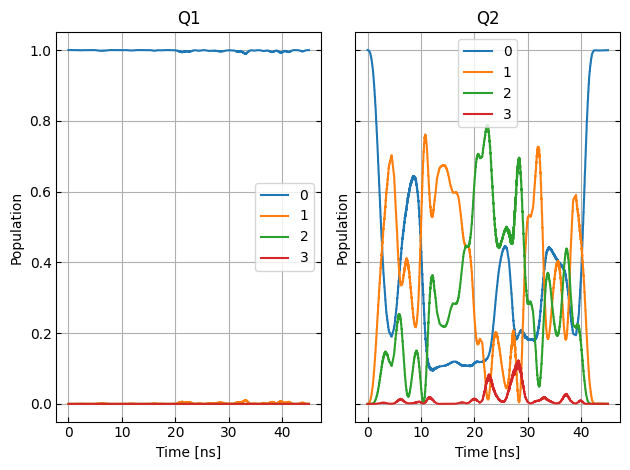

In [94]:
plot_dynamics(exp, init_state, sequence)
plotSplittedPopulation(exp, init_state, sequence)

Now we plot the dynamics for the control in the excited state.

tf.Tensor(
[[0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [1.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]], shape=(16, 1), dtype=complex128)


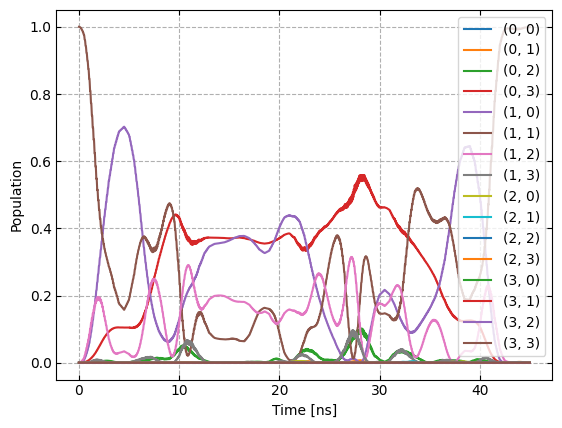

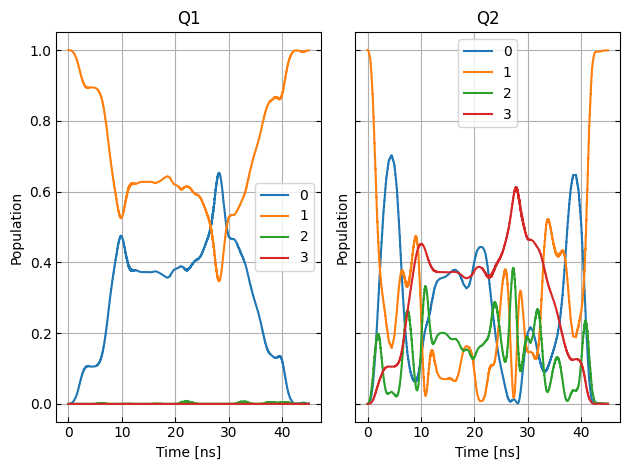

In [95]:
psi_init = [[0] * qubit_lvls ** 2]
psi_init[0][qubit_lvls + 1] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
print(init_state)

plot_dynamics(exp, init_state, sequence)
plotSplittedPopulation(exp, init_state, sequence)

As intended, the dynamics of the target is dependent on the control qubit performing a flip if the control is excited and an identity otherwise.